# Principle Component Analysis (PCA) Transformation and Data Vis
PCA offers the possibility of reducing higher dimensionality into 

In [1]:
#plotly imports 
import plotly as py 
import plotly.graph_objs as go
from plotly import __version__

#use this format for working locally 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, plot_mpl
init_notebook_mode(connected=True)
print('Plotly version: %s' %(__version__))


#Data Containers & Essential Libraries
import data_prep as dp
import pandas as pd
import numpy as np
import pickle as pkl

# Alternate visualization
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

Plotly version: 3.3.0


In [2]:
# Load in feature and target variables, taking only a small sample for visualization
data, target = dp.load_agg_Xy(path='./data/', strat_cat='attack_cat', sample_size=0.05, rnd_state=0)

# Import one-hot-encoding and standard scaling for the full feature set
with open('ct_ohe_ssc_xyagg.pkl', 'rb') as f:
    col_trans = pkl.load(f)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: DtypeWarning:

Columns (1,3,47) have mixed types. Specify dtype option on import or set low_memory=False.

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: DtypeWarning:

Columns (3,39,47) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
# Create pipeline that transforms columns and performs PCA on the resulting features
pca = PCA(n_components = 3, random_state=0)
ct_pca = Pipeline([
    ('col_transform', col_trans),
    ('pca', pca)
])

# Produce array of PCA-transformed data
X_pca = ct_pca.fit_transform(data)

# Reduce massive outliers that prohibit the graph from focusing on macro trends in the data
to_keep = dp.reject_outliers(X_pca, m=8)
X_pca = X_pca[to_keep]
y_pca = target[to_keep]

ct_pca.named_steps['pca'].explained_variance_ratio_

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



array([0.25595334, 0.12764419, 0.09515227])

In [4]:
atk_msk = (y_pca!='normal')
attack_rows = np.sum(atk_msk)
norm_rows = X_pca.shape[0]-attack_rows
atk_dat = X_pca[atk_msk][np.random.choice(attack_rows, size=2500, replace=False)]
norm_dat = X_pca[~atk_msk][np.random.choice(norm_rows, size=2500, replace=False)]


In [5]:
# Graphing 3-D reduced data
marker_pos = dict(size=3, symbol='circle',
                  #color='rgb(127, 127, 127)',
                  color = 'rgb(255, 127, 14)',
                  #line=dict(width=1, color='rgba(217, 217, 217, 0.14)'),
                  opacity=0.3)
marker_neg = dict(size=3, symbol='circle',
                  color='rgb(127, 127, 127)',
                  #line=dict(color='rgb(204, 204, 204)',width=0.5),
                  opacity=0.8)

# Store data and associated marker info in "traces"
trace1 = go.Scatter3d(x = atk_dat[:,0], y=atk_dat[:,1], z=atk_dat[:,2],
                    mode = 'markers',
                     marker = marker_pos,
                     name = 'Cyberattack examples')

trace2 = go.Scatter3d(x = norm_dat[:,0], y=norm_dat[:,1], z=norm_dat[:,2],
                    mode = 'markers',
                     marker = marker_neg,
                     name = 'Normal Traffic')
data_plotly=[trace1, trace2]

layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ),
    title = 'Scania Truck Data Reduced to 3 Components',
    xaxis = dict(title = 'PC1', titlefont = dict(size=18)),
    yaxis = dict(title = 'PC2', titlefont = dict(size=18)),
    #zaxis = dict(title = 'PC3', titlefont = dict(size=18))
)
fig = go.Figure(data=data_plotly, layout=layout)
py.offline.iplot(fig, filename='simple-3d-scatter')

From the above, I'm noticing a real nice separation for values with principal component 1 (PC1) when PC1 is less than zero. Let's take a look at the values in `X_pca`s first column and see if there are any patterns in the target labels.

In [6]:
y_pca[X_pca[:,0]<0].value_counts()

normal            37003
generic           10622
exploits            827
dos                 636
fuzzers             418
reconnaissance      344
analysis             99
backdoors            97
shellcode            48
Name: attack_cat, dtype: int64

In [7]:
y_pca.value_counts()

normal            110789
generic            10772
exploits            2213
fuzzers             1202
dos                  811
reconnaissance       699
analysis             134
backdoors            116
shellcode             76
worms                  9
Name: attack_cat, dtype: int64

# TSNE Visualization of Attacks

In [90]:
tsne = TSNE(random_state=10)
atk_tsne = tsne.fit_transform(col_trans.fit_transform(data[target!='normal']))

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



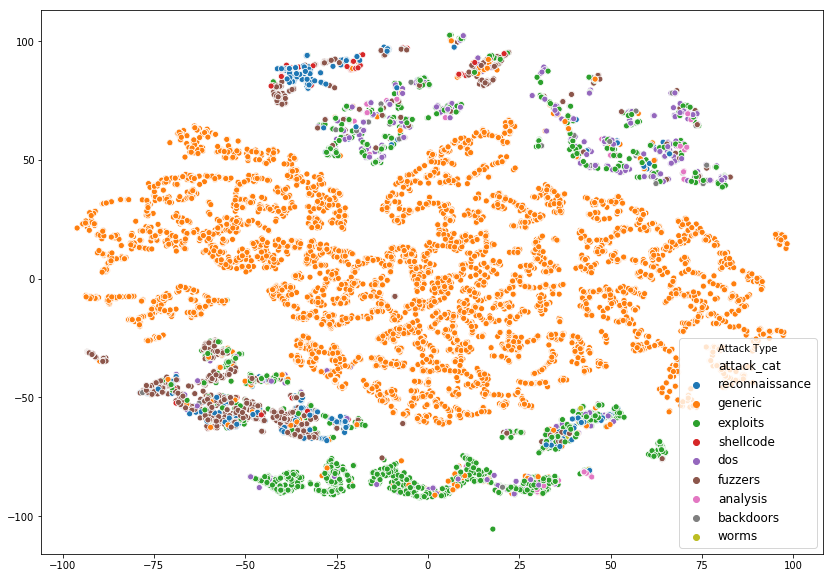

In [91]:
plt.figure(figsize=[14,10])
sns.scatterplot(x=atk_tsne[:,0], y=atk_tsne[:,1], hue=target[target!='normal'])
#plt.axis('off')
plt.legend(loc=4, prop={'size': 12}, title='Attack Type');
#plt.savefig('./images_and_slides/attack_tsne.png');

In [11]:
type(atk_tsne)

numpy.ndarray

In [31]:
# Getting a dataframe with the same indices as 'atk_tsne' array.
# Using this, I can then select for column values and get indices that match
atk_df = data[target!='normal'].reset_index(drop=True)
tgt_df = target[target!='normal'].reset_index(drop=True)

# Confirm that shapes are the same
np.shape(atk_tsne), np.shape(atk_df)

((16064, 2), (16064, 39))

In [53]:
atk_df.head()

Name,proto,state,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,service,...,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm
0,other,int,0.000008,200,0,254,0,0,0,-,...,0.0,0,0,6,6,2,3,2,2,6
1,udp,int,0.000009,114,0,254,0,0,0,dns,...,0.0,0,0,36,36,36,37,36,18,36
2,udp,int,0.000009,114,0,254,0,0,0,dns,...,0.0,0,0,38,38,22,23,22,22,38
3,other,int,0.000010,200,0,254,0,0,0,-,...,0.0,0,0,8,8,5,5,3,3,10
4,tcp,fin,3.979308,932,4158,62,252,7,9,other,...,0.0,0,0,1,1,1,3,1,1,1


In [63]:
atk_df.proto.unique()

array(['other', 'udp', 'tcp', 'unas'], dtype=object)

In [100]:
#msk_tsne = (tgt_df == 'reconnaissance') #| (tgt_df=='fuzzers')
msk_tsne = (tgt_df == 'reconnaissance') | (tgt_df=='fuzzers')
#msk_tsne = atk_df.proto == 'tcp'

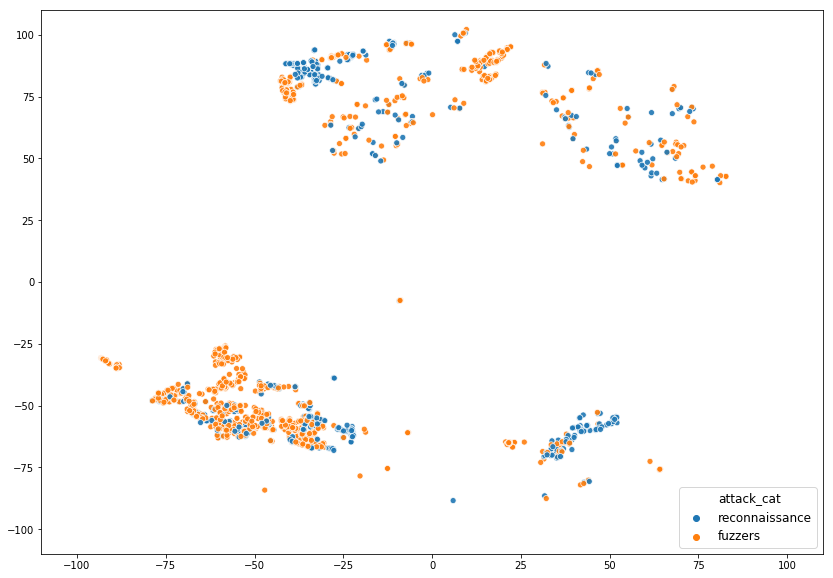

In [101]:
plt.figure(figsize=[14,10])
sns.scatterplot(x=atk_tsne[msk_tsne,0],
                y=atk_tsne[msk_tsne,1],
                alpha=0.9,
                hue=tgt_df[msk_tsne])
                
#plt.axis('off')
plt.ylim((-110,110))
plt.xlim((-110,110))
plt.legend(loc=4, prop={'size': 12});

In [ ]:
atk_df.groupby(['a'])